Calculate the probability of being born in a continent (e.g. Asia) compared to global population, plus:

Average country population per region

Visualize top regions by birth probability

In [3]:
# Data fetch from API
import requests

url = 'https://restcountries.com/v3.1/all?fields=name,population,region'
response = requests.get(url)
data = response.json()
print(len(data))
print(type(data))

250
<class 'list'>


In [8]:
# varify data
print(data[0])
print(data[0]['name']['common'])
print(data[0]['population'])
print(data[0]['region'])

{'name': {'common': 'Moldova', 'official': 'Republic of Moldova', 'nativeName': {'ron': {'official': 'Republica Moldova', 'common': 'Moldova'}}}, 'region': 'Europe', 'population': 2617820}
Moldova
2617820
Europe


In [9]:
# make dataframe
import pandas as pd

df = pd.json_normalize(data)
df.head()

,region,population,name.common,name.official,name.nativeName.ron.official,name.nativeName.ron.common,name.nativeName.ara.official,name.nativeName.ara.common,name.nativeName.fra.official,name.nativeName.fra.common,...,name.nativeName.sna.official,name.nativeName.sna.common,name.nativeName.toi.official,name.nativeName.toi.common,name.nativeName.zib.official,name.nativeName.zib.common,name.nativeName.mfe.official,name.nativeName.mfe.common,name.nativeName.aze.official,name.nativeName.aze.common
0,Europe,2617820,Moldova,Republic of Moldova,Republica Moldova,Moldova,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa,869595,Comoros,Union of the Comoros,NaN,NaN,الاتحاد القمري,القمر‎,Union des Comores,Comores,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Asia,32365998,Malaysia,Malaysia,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa,44700000,Algeria,People's Democratic Republic of Algeria,NaN,NaN,الجمهورية الديمقراطية الشعبية الجزائرية,الجزائر,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Oceania,2302,Norfolk Island,Territory of Norfolk Island,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# condition data
df = df[['region','population','name.common']]

df = df.rename(columns={'name.common':'country_name','region':'region_name'})

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region_name   250 non-null    object
 1   population    250 non-null    int64 
 2   country_name  250 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.0+ KB


In [15]:
# put it to sqlite database
import sqlite3
import pprint

conn = sqlite3.connect("avgpopulation.db",isolation_level=None)
df.to_sql("avg_tbl",conn,if_exists='replace',index=False)

pprint.pprint(conn.execute('SELECT name FROM sqlite_schema WHERE type="table"').fetchall())
pprint.pprint(conn.execute('SELECT * FROM avg_tbl LIMIT 5').fetchall())
pprint.pprint(conn.execute('PRAGMA TABLE_INFO("avg_tbl")').fetchall())

[('avg_tbl',)]
[('Europe', 2617820, 'Moldova'),
 ('Africa', 869595, 'Comoros'),
 ('Asia', 32365998, 'Malaysia'),
 ('Africa', 44700000, 'Algeria'),
 ('Oceania', 2302, 'Norfolk Island')]
[(0, 'region_name', 'TEXT', 0, None, 0),
 (1, 'population', 'INTEGER', 0, None, 0),
 (2, 'country_name', 'TEXT', 0, None, 0)]


In [28]:
# SQL to Pandas for Math

# fetch region total population from database avpopulation.db
# check rule for agregation, how many column need to be included?
quary = """
SELECT region_name, SUM(population) as reginal_population
FROM avg_tbl
GROUP BY region_name
"""
df_regions = pd.read_sql_query(quary,conn)

# World population
world_population = df_regions['reginal_population'].sum()
print('Total world population: ',world_population)

# Calculate probility and add column
df_regions['region_probability'] = df_regions['reginal_population'] / world_population
pprint.pprint(df_regions)

# Avarage population by region
quary="""
SELECT region_name, AVG(population) as reginal_avg
FROM avg_tbl
GROUP BY region_name
"""
df_avg_region = pd.read_sql_query(quary,conn)
pprint.pprint(df_avg_region)

# merge two df
df_final = pd.merge(df_regions, df_avg_region, on='region_name')
pprint.pprint(df_final)

Total world population:  7777721563
  region_name  reginal_population  region_probability
0      Africa          1362095235        1.751278e-01
1    Americas          1020976420        1.312693e-01
2   Antarctic                1430        1.838585e-07
3        Asia          4604594974        5.920236e-01
4      Europe           746934072        9.603507e-02
5     Oceania            43119432        5.543967e-03
  region_name   reginal_avg
0      Africa  2.308636e+07
1    Americas  1.823172e+07
2   Antarctic  2.860000e+02
3        Asia  9.209190e+07
4      Europe  1.409310e+07
5     Oceania  1.597016e+06
  region_name  reginal_population  region_probability   reginal_avg
0      Africa          1362095235        1.751278e-01  2.308636e+07
1    Americas          1020976420        1.312693e-01  1.823172e+07
2   Antarctic                1430        1.838585e-07  2.860000e+02
3        Asia          4604594974        5.920236e-01  9.209190e+07
4      Europe           746934072        9.603507e

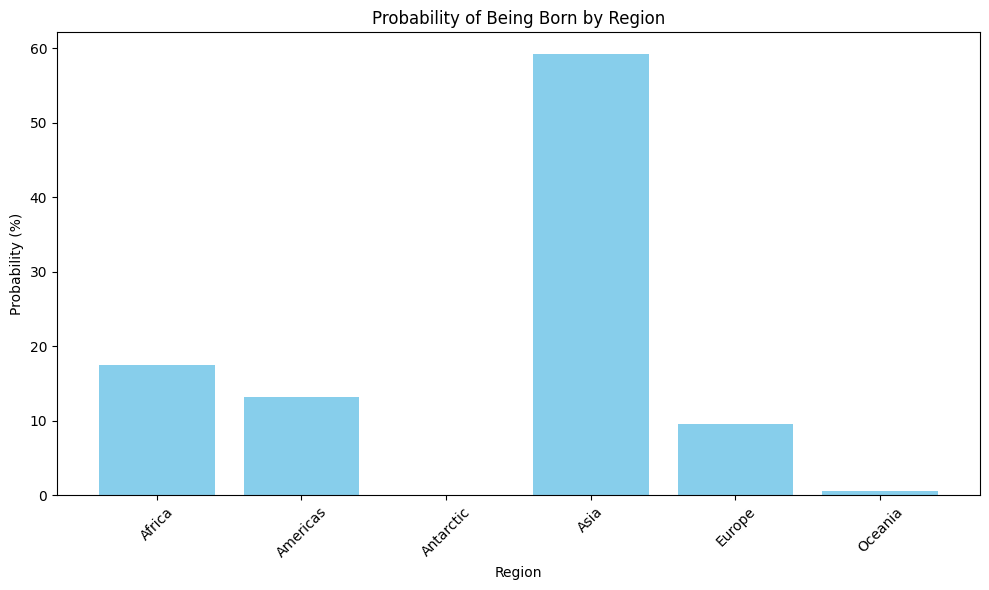

  region_name  reginal_population  region_probability   reginal_avg
0      Africa          1362095235        1.751278e-01  2.308636e+07
1    Americas          1020976420        1.312693e-01  1.823172e+07
2   Antarctic                1430        1.838585e-07  2.860000e+02
3        Asia          4604594974        5.920236e-01  9.209190e+07
4      Europe           746934072        9.603507e-02  1.409310e+07
5     Oceania            43119432        5.543967e-03  1.597016e+06


In [30]:
# pandas to visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(df_final['region_name'], df_final['region_probability'] * 100, color='skyblue')
plt.xlabel("Region")
plt.ylabel("Probability (%)")
plt.title("Probability of Being Born by Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(df_final[['region_name', 'reginal_population', 'region_probability', 'reginal_avg']])

Asia dominates: Nearly 60% of the global population lives in Asia — meaning a randomly born person is most likely to be born there.

Africa is next, contributing around 17.5%, showing its growing demographic weight.

Antarctica is practically negligible, showing up just to prove the planet’s diversity.

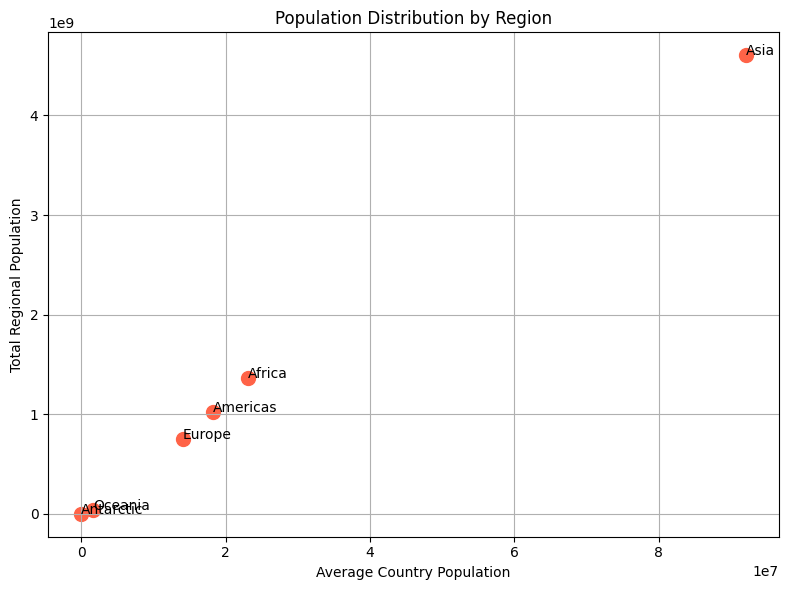

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_final['reginal_avg'], df_final['reginal_population'], color='tomato', s=100)

#labal the spots
for i in range(len(df_final)):
    plt.text(df_final['reginal_avg'][i], df_final['reginal_population'][i], df_final['region_name'][i])

plt.xlabel("Average Country Population")
plt.ylabel("Total Regional Population")
plt.title("Population Distribution by Region")
plt.grid(True)
plt.tight_layout()
plt.show()


Asia stands out with both high total population and high average country population — driven by populous giants like India and China.

Oceania and Europe have relatively low average country populations, indicating their nations tend to be smaller and more balanced.

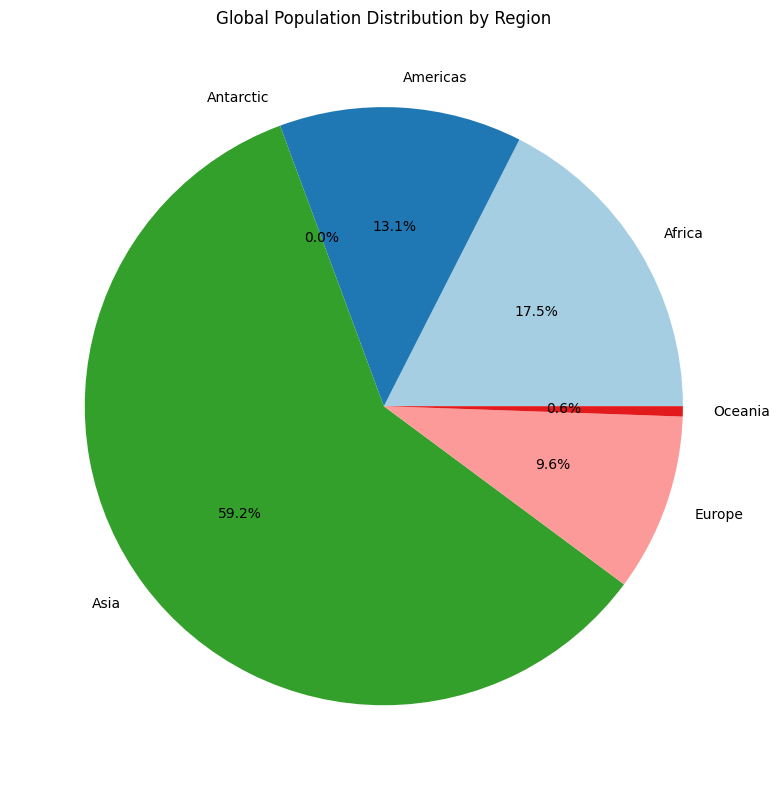

In [32]:
plt.figure(figsize=(8,8))
plt.pie(df_final['region_probability'], labels=df_final['region_name'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Global Population Distribution by Region")
plt.tight_layout()
plt.show()


This visual highlights just how skewed global population distribution is — with Asia forming the lion’s share, while Antarctica exists as more of a control variable than a populated zone.

Demographic concentration is uneven, with over 70% of the world’s population located in Asia and Africa alone — indicating significant focus zones for education, healthcare, and infrastructure analytics.

Average country populations can mask diversity within regions: Asia's average is high because it includes some of the most populous nations globally, while Oceania's low average reflects the presence of many island nations.

Antarctica as a statistical outlier reminds us to watch for zero-population zones when aggregating or visualizing da